In [2]:
import pyrealsense2 as rs
import numpy as np
import matplotlib.pyplot as plt
import time
from math import sin, cos, tan, radians
from IPython.display import clear_output

In [3]:
class Realsense_Camera:
    def __init__(self):
        self.pipe = rs.pipeline()
        self.profile = self.pipe.start()

    def get_depth_frame(self):
        return self.pipe.wait_for_frames().get_depth_frame()

    def close(self):
        self.pipe.stop()

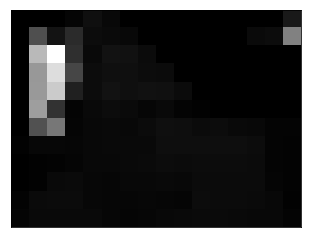

Frame took: 0.8130s


In [4]:
def build(df, shape=(3, 4)):
    # 3:4 ratio -> shape should be 3*i, 4*i i=[2,4,8, 16]
    assert isinstance(df, rs.depth_frame)
    grid = np.array(df.get_data())
    grid = mean_reBin(grid, shape)
    return grid


def min_reBin(a, shape):
    sh = shape[0], a.shape[0]//shape[0], shape[1], a.shape[1]//shape[1]
    return a.reshape(sh).min(axis=3).min(axis=1)


def mean_reBin(a, shape):
    sh = shape[0], a.shape[0]//shape[0], shape[1], a.shape[1]//shape[1]
    return a.reshape(sh).mean(axis=3).mean(axis=1)


def max_reBin(a, shape):
    sh = shape[0], a.shape[0]//shape[0], shape[1], a.shape[1]//shape[1]
    return a.reshape(sh).max(axis=3).max(axis=1)


def test():
    cam = Realsense_Camera()
    if cam is not None:
        print 'connected to camera'
        for _ in range(1):
            start_time = time.time()
            grid = build(cam.get_depth_frame(), shape=(12, 16))
            clear_output(wait=True)
            plt.imshow(grid, cmap='gray')
            plt.xticks(())
            plt.yticks(())
            plt.show()
            print('Frame took: ' + "{:.4f}".format(time.time()-start_time) + 's')
            time.sleep(0.5)
    cam.close()


test()
# cam.close()

In [106]:
cam = Realsense_Camera()

for x in range(5):
    time.sleep(0.5)
    cam.get_depth_frame()

frame = cam.get_depth_frame()
cam.close()

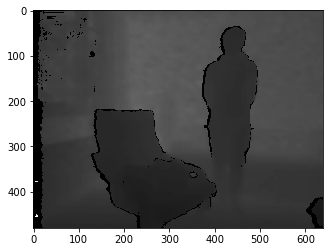

In [107]:
df = np.array(frame.get_data())
plt.imshow(df, cmap='gray')

In [108]:
def toKoord(dist_array, cam_pitch=0, cam_yaw=0, cam_position=(0, 0, 0)):
    """
    realSense d435 depthcam -> 86°x57° FOV
    :param cam_angel: camara pitch/drone tilt
    :param cam_yaw: yaw of camera/drone
    :param cam_position: gps location of camera
    :param dist_array: array of distances in mm 
    """
    da = max_reBin(dist_array, (120, 160))
    vec_arr = []
    for j in xrange(120):
        for i in xrange(160):
            if da[j][i] != 0.0:
                alpha = (47.0 + (2*i + 1)*(43.0/160)) # Grad X|Y
                beta = (28.5 - (2*j + 1)*(28.5/120)) # Grad Y|Z
                r = da[j][i]
                vec = np.array([r*cos(radians(beta))*sin(radians(alpha)),
                                r*cos(radians(beta))*cos(radians(alpha)),
                                r*sin(radians(beta))])
                if (vec < 3000).all() and (vec[2] < 150) and (vec[2] > -150):
                    vec_arr.append(vec)
    return np.array(vec_arr)

cor = toKoord(dist_array=df)

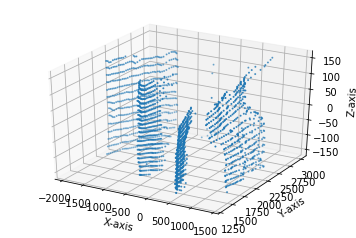

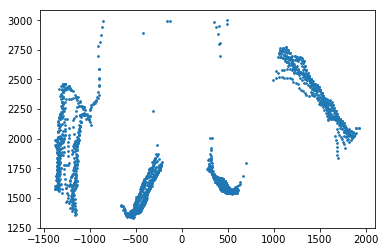

In [109]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
cor = cor.T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(cor[1], cor[0], cor[2], marker='o', s=1)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

plt.show()
plt.close()

plt.scatter(-cor[1], cor[0], s=3);

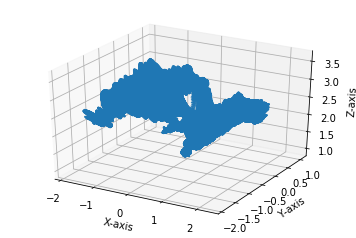

In [94]:
pc = rs.pointcloud()
pointcloud = pc.calculate(frame)
a = np.array(pointcloud.get_vertices())
b = np.array([[i[0], i[1], i[2]] for i in a if not ((i[0] == 0.) or (i[1] == 0.) or (i[0] < -4))]).T

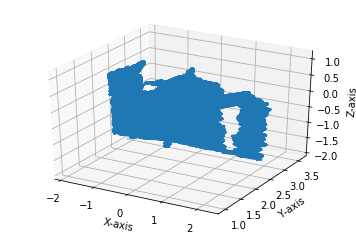

In [95]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(b[0], b[2], b[1], marker='o', s=1)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

plt.show()
plt.close()